In [2]:
import os
# import drjit
gpu_num = 5 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
# tf.config.run_functions_eagerly(True)

from jammer.simulation_model import *
from jammer.utils import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

In [3]:
# common parameters
model_parameters = {}
jammer_parameters = {}
model_parameters["perfect_csi"] = False
model_parameters["num_ut"] = 1
model_parameters["jammer_present"] = True
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
model_parameters["num_silent_pilot_symbols"] = 4
model_parameters["coderate"] = 0.5
jammer_parameters["trainable"] = False
model_parameters["jammer_parameters"] = jammer_parameters

#### BLER with Jammer Weights Trained on Uncoded Channel

- Single-UE Baseline: Coded channel. Take any Jammer Power which makes sense
    - Uniform Jammer
    - Pilot Jammer
    - All-Data Jammer
    - One-Data Jammer
    - Two-Data Jammer
- Trained Single-UE Jammer trained with same power (in uncoded channel)

In [ ]:
jammer_power = 1.0
# 0-3 silent, 4 pilot, 5-13 data
# Name, shaped_rho
parameters = [
    ("Uniform", jammer_power * normalize_power(tf.concat([tf.zeros([4,1]), tf.ones([10,1])], axis=0))),
    ("Pilot", jammer_power * normalize_power(tf.concat([tf.zeros([4,1]), tf.ones([1,1]), tf.zeros([9,1])], axis=0))),
    ("One Data Symbol", jammer_power * normalize_power(tf.concat([tf.zeros([5,1]), tf.ones([1,1]), tf.zeros([8,1])], axis=0))),
    ("Two Data Symbols", jammer_power * normalize_power(tf.concat([tf.zeros([5,1]), tf.ones([2,1]), tf.zeros([7,1])], axis=0))),
    ("All Data Symbols", jammer_power * normalize_power(tf.concat([tf.zeros([5,1]), tf.ones([9,1])], axis=0))),
]
sim.BATCH_SIZE = 32
sim.MAX_MC_ITER = 1000
for name, rho in parameters:
    model = Model(**model_parameters, jammer_power=rho)
    simulate_model(model, name, add_bler=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.1485e-01 | 1.0000e+00 |    11606462 |    36864000 |        32000 |       32000 |       196.3 |reached max iter       
   -3.571 | 3.0877e-01 | 1.0000e+00 |    11382318 |    36864000 |        32000 |       32000 |       181.1 |reached max iter       
   -2.143 | 3.0511e-01 | 1.0000e+00 |    11247578 |    36864000 |        32000 |       32000 |       179.5 |reached max iter       
   -0.714 | 3.0349e-01 | 1.0000e+00 |    11187949 |    36864000 |        32000 |       32000 |       177.9 |reached max iter       
    0.714 | 3.0312e-01 | 1.0000e+00 |    11174241 |    36864000 |        32000 |       32000 |       177.9 |reached max iter       
    2.143 | 3.0365e-01 | 1.0000e+00 |    11193830 |    36864000 |        32000 |     

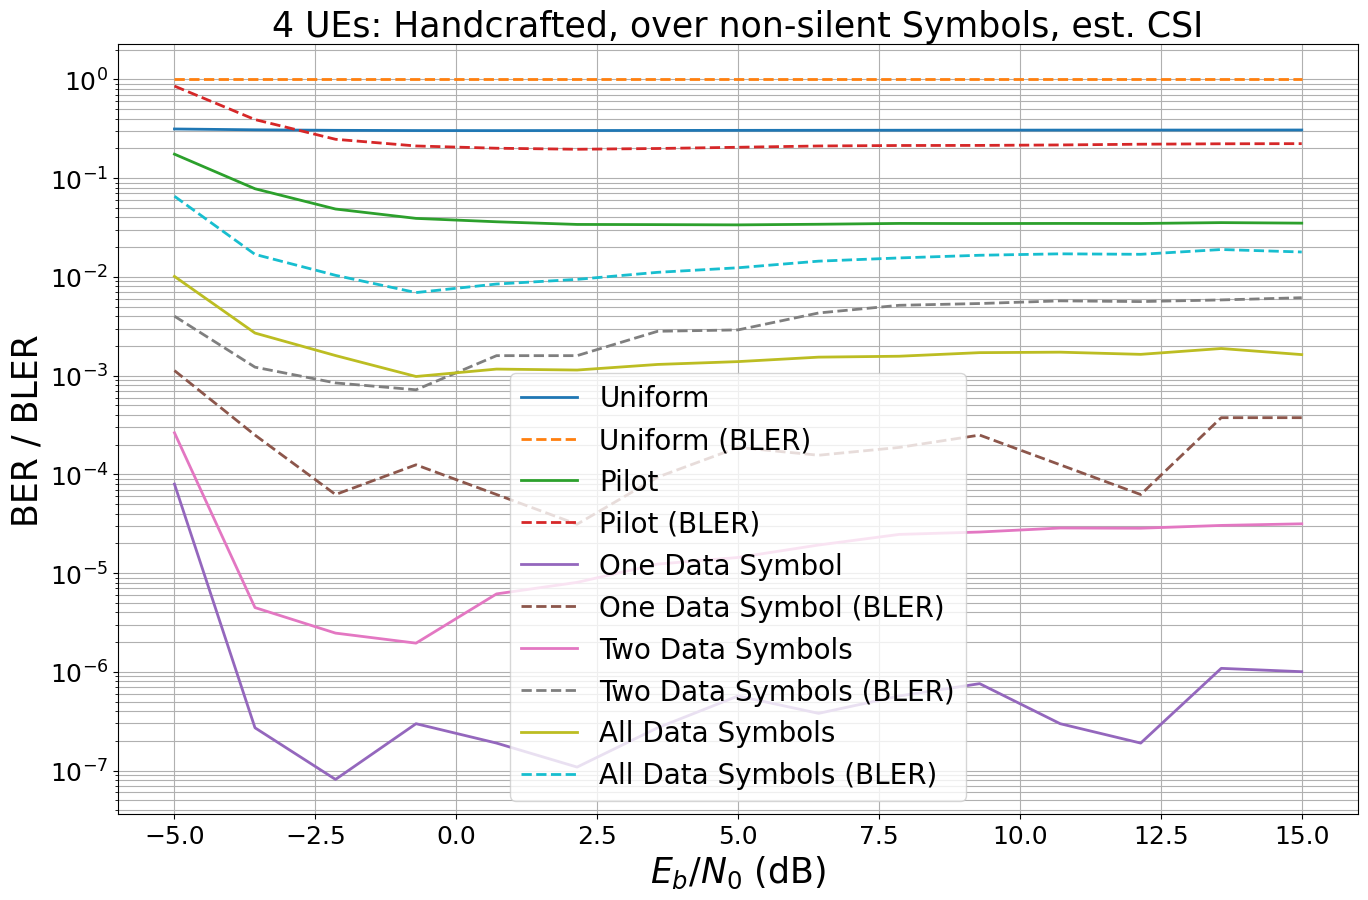

In [ ]:
ber_plots.title = "Handcrafted, over non-silent Symbols, est. CSI"
ber_plots()

In [3]:
ber_plots.reset()
sim.BATCH_SIZE = 32
sim.MAX_MC_ITER = 300
filename = "weights/ue_1_relufix_symbol_weights.pickle"
my_model_parameters = {**model_parameters,
                       "jammer_parameters": {**jammer_parameters, "trainable_mask": tf.ones([14,1], dtype=tf.bool)}}
model = Model(**my_model_parameters)
load_weights(model, filename)
simulate_model(model, "1 UE, trained in uncoded channel", add_bler=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.8926e-01 | 1.0000e+00 |     4304864 |    11059200 |         9600 |        9600 |        60.2 |reached max iter       
   -3.571 | 3.8761e-01 | 1.0000e+00 |     4286684 |    11059200 |         9600 |        9600 |        52.9 |reached max iter       
   -2.143 | 3.8624e-01 | 1.0000e+00 |     4271544 |    11059200 |         9600 |        9600 |        52.9 |reached max iter       
   -0.714 | 3.8614e-01 | 1.0000e+00 |     4270453 |    11059200 |         9600 |        9600 |        52.4 |reached max iter       
    0.714 | 3.8638e-01 | 1.0000e+00 |     4273054 |    11059200 |         9600 |        9600 |        52.4 |reached max iter       
    2.143 | 3.8683e-01 | 1.0000e+00 |     4278085 |    11059200 |         9600 |     

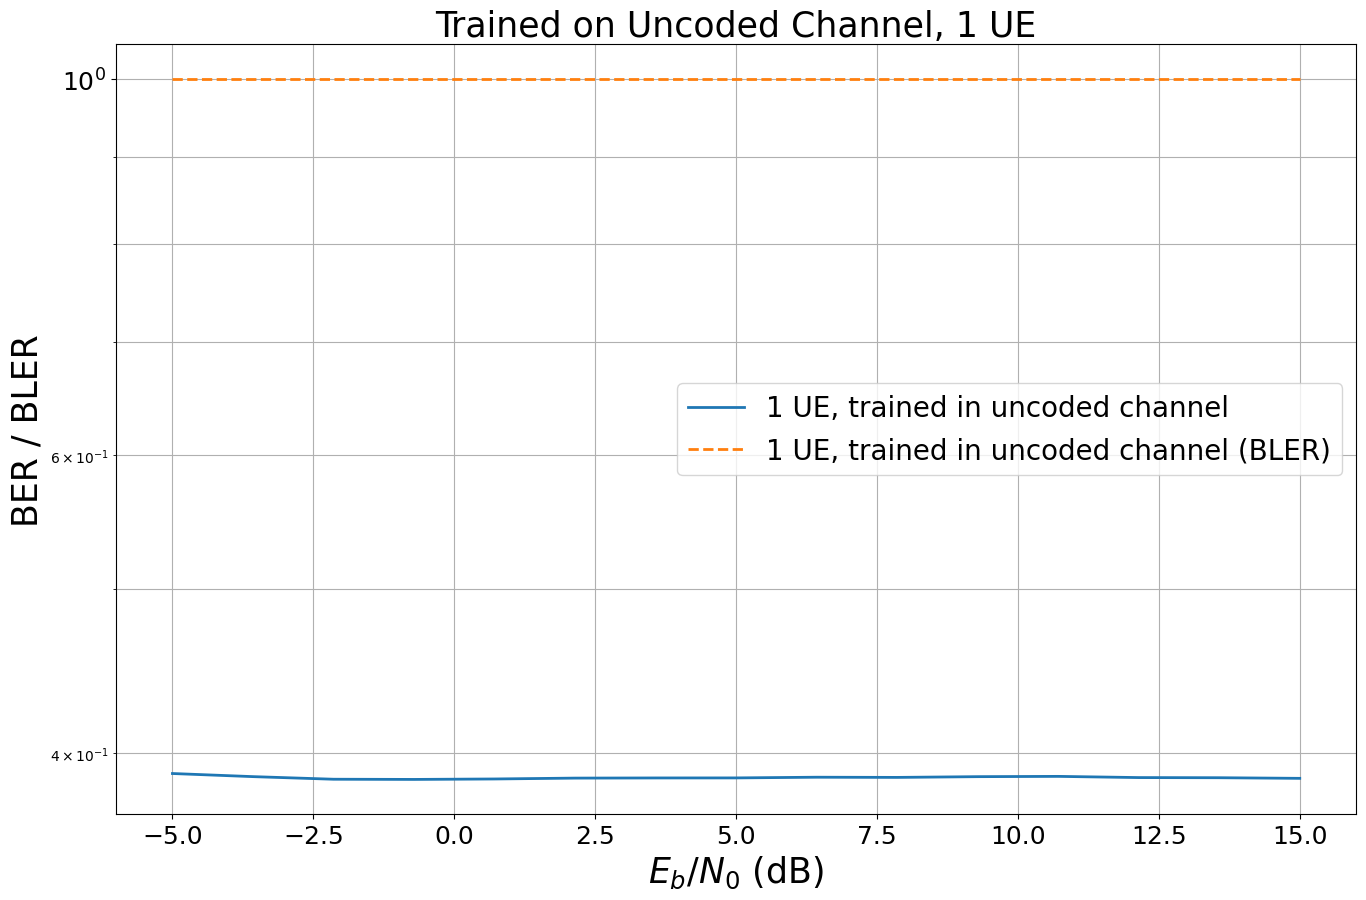

In [4]:
ber_plots.title = "Trained on Uncoded Channel, 1 UE"
ber_plots()

- Multi-UE Baseline: Coded channel. Take any jammer power which makes sense
    - Same as above
- Trained Multi-UE jammer with same power

In [ ]:
ber_plots.reset()
model_parameters["num_ut"] = 4
jammer_power = 1.0
# 0-3 silent, 4 pilot, 5-13 data
# Name, shaped_rho
parameters = [
    ("Uniform", jammer_power * normalize_power(tf.concat([tf.zeros([4,1]), tf.ones([10,1])], axis=0))),
    ("Pilot", jammer_power * normalize_power(tf.concat([tf.zeros([4,1]), tf.ones([4,1]), tf.zeros([6,1])], axis=0))),
    ("One Data Symbol", jammer_power * normalize_power(tf.concat([tf.zeros([8,1]), tf.ones([1,1]), tf.zeros([5,1])], axis=0))),
    ("Two Data Symbols", jammer_power * normalize_power(tf.concat([tf.zeros([8,1]), tf.ones([2,1]), tf.zeros([4,1])], axis=0))),
    ("All Data Symbols", jammer_power * normalize_power(tf.concat([tf.zeros([8,1]), tf.ones([6,1])], axis=0))),
]
sim.BATCH_SIZE = 32
sim.MAX_MC_ITER = 1000
for name, rho in parameters:
    model = Model(**model_parameters, jammer_power=rho)
    simulate_model(model, name, add_bler=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 5.3329e-02 | 7.1291e-01 |     5242408 |    98304000 |        22813 |       32000 |       194.1 |reached max iter       
   -3.571 | 2.7947e-02 | 4.4488e-01 |     2747335 |    98304000 |        14236 |       32000 |       184.7 |reached max iter       
   -2.143 | 1.7938e-02 | 3.0762e-01 |     1763372 |    98304000 |         9844 |       32000 |       182.6 |reached max iter       
   -0.714 | 1.3563e-02 | 2.6259e-01 |     1333337 |    98304000 |         8403 |       32000 |       183.0 |reached max iter       
    0.714 | 1.2130e-02 | 2.6972e-01 |     1192446 |    98304000 |         8631 |       32000 |       184.0 |reached max iter       
    2.143 | 1.1976e-02 | 3.0494e-01 |     1177245 |    98304000 |         9758 |     

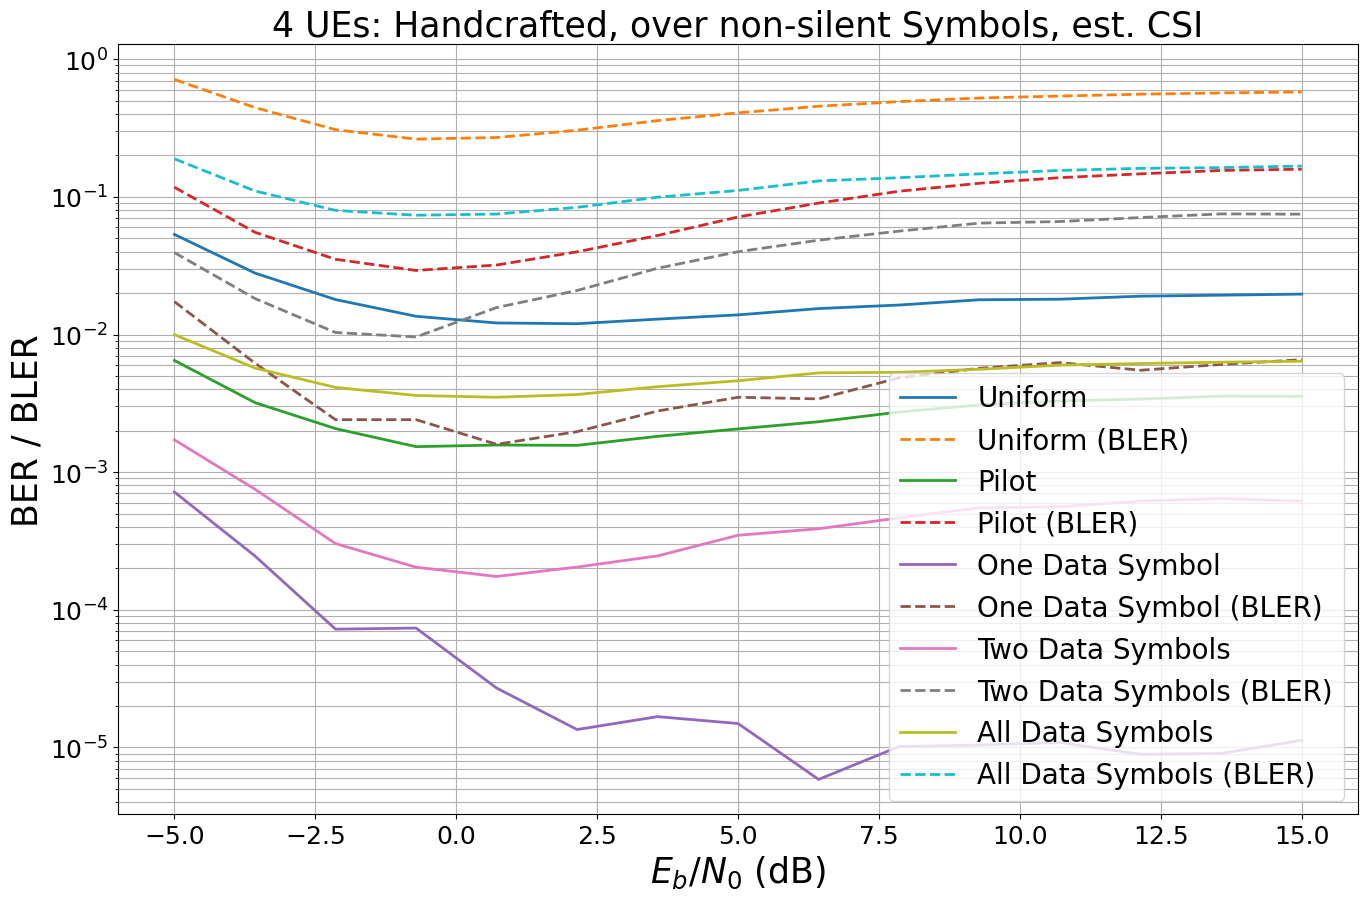

In [ ]:
ber_plots.title = "4 UEs: Handcrafted, over non-silent Symbols, est. CSI"
ber_plots()
# from copy import deepcopy
# ber_plots_copy = deepcopy(ber_plots)
# for i in range(20):
#     ber_plots_copy.remove(0)
# ber_plots_copy()

In [5]:
ber_plots.reset()
sim.BATCH_SIZE = 32
sim.MAX_MC_ITER = 300
filename = "weights/ue_4_relufix_symbol_weights.pickle"
my_model_parameters = {**model_parameters,
                       "jammer_parameters": {**jammer_parameters, "trainable_mask": tf.ones([14,1], dtype=tf.bool)}}
model = Model(**my_model_parameters)
load_weights(model, filename)
simulate_model(model, "4 UE, trained in uncoded channel", add_bler=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.0550e-02 | 1.3729e-01 |      227263 |    11059200 |         1318 |        9600 |        59.6 |reached max iter       
   -3.571 | 5.9512e-03 | 3.9271e-02 |       65815 |    11059200 |          377 |        9600 |        53.0 |reached max iter       
   -2.143 | 3.2221e-03 | 2.1250e-02 |       35634 |    11059200 |          204 |        9600 |        53.0 |reached max iter       
   -0.714 | 2.3847e-03 | 1.7708e-02 |       26373 |    11059200 |          170 |        9600 |        52.8 |reached max iter       
    0.714 | 2.0511e-03 | 1.8021e-02 |       22684 |    11059200 |          173 |        9600 |        52.6 |reached max iter       
    2.143 | 1.8312e-03 | 1.7812e-02 |       20252 |    11059200 |          171 |     

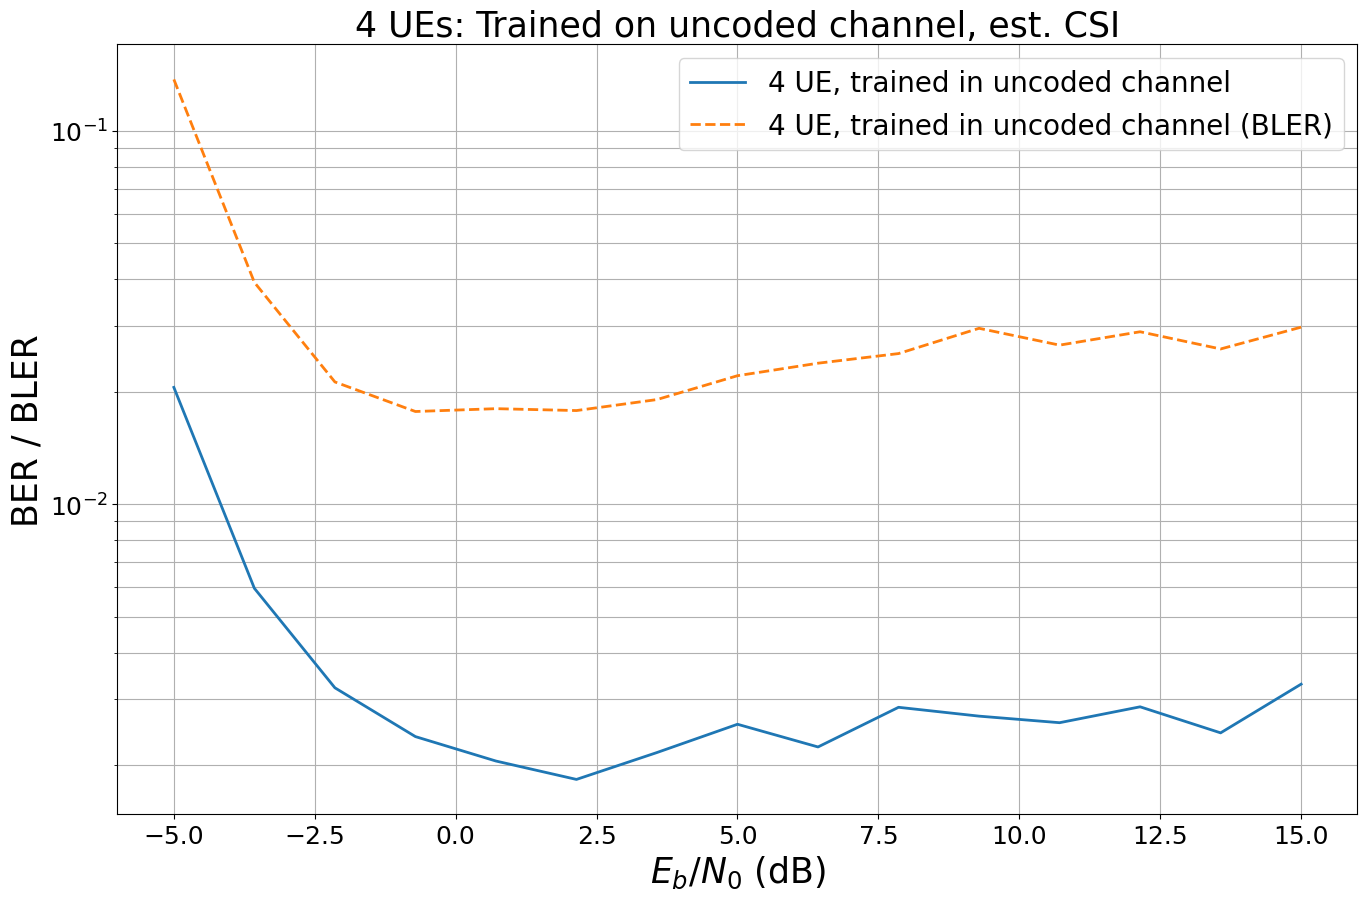

In [6]:
ber_plots.title = "4 UEs: Trained on uncoded channel, est. CSI"
ber_plots()

#### BLER with Jammer Weights Trained on Information Bits of Coded Channel

- take same power as above and train
    - single-UE
    - multi-UE

In [4]:
ber_plots.reset()
sim.BATCH_SIZE = 32
sim.MAX_MC_ITER = 150
num_ue = [1, 4]
for num in num_ue:
    filename = f"weights/ue_{num}_coded_symbol_weights.pickle"
    my_model_parameters = {**model_parameters,
                           "jammer_parameters": {**jammer_parameters, "trainable_mask": tf.ones([14,128], dtype=tf.bool)}}
    model = Model(**my_model_parameters)
    load_weights(model, filename)
    simulate_model(model, f"{num} UE, trained in coded channel (RG weights)", add_bler=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.7363e-01 | 1.0000e+00 |     2066017 |     5529600 |         4800 |        4800 |        38.4 |reached max iter       
   -3.571 | 3.7018e-01 | 1.0000e+00 |     2046950 |     5529600 |         4800 |        4800 |        26.0 |reached max iter       
   -2.143 | 3.6810e-01 | 1.0000e+00 |     2035463 |     5529600 |         4800 |        4800 |        23.7 |reached max iter       
   -0.714 | 3.6576e-01 | 1.0000e+00 |     2022487 |     5529600 |         4800 |        4800 |        23.0 |reached max iter       
    0.714 | 3.6443e-01 | 1.0000e+00 |     2015160 |     5529600 |         4800 |        4800 |        23.7 |reached max iter       
    2.143 | 3.6255e-01 | 1.0000e+00 |     2004755 |     5529600 |         4800 |     

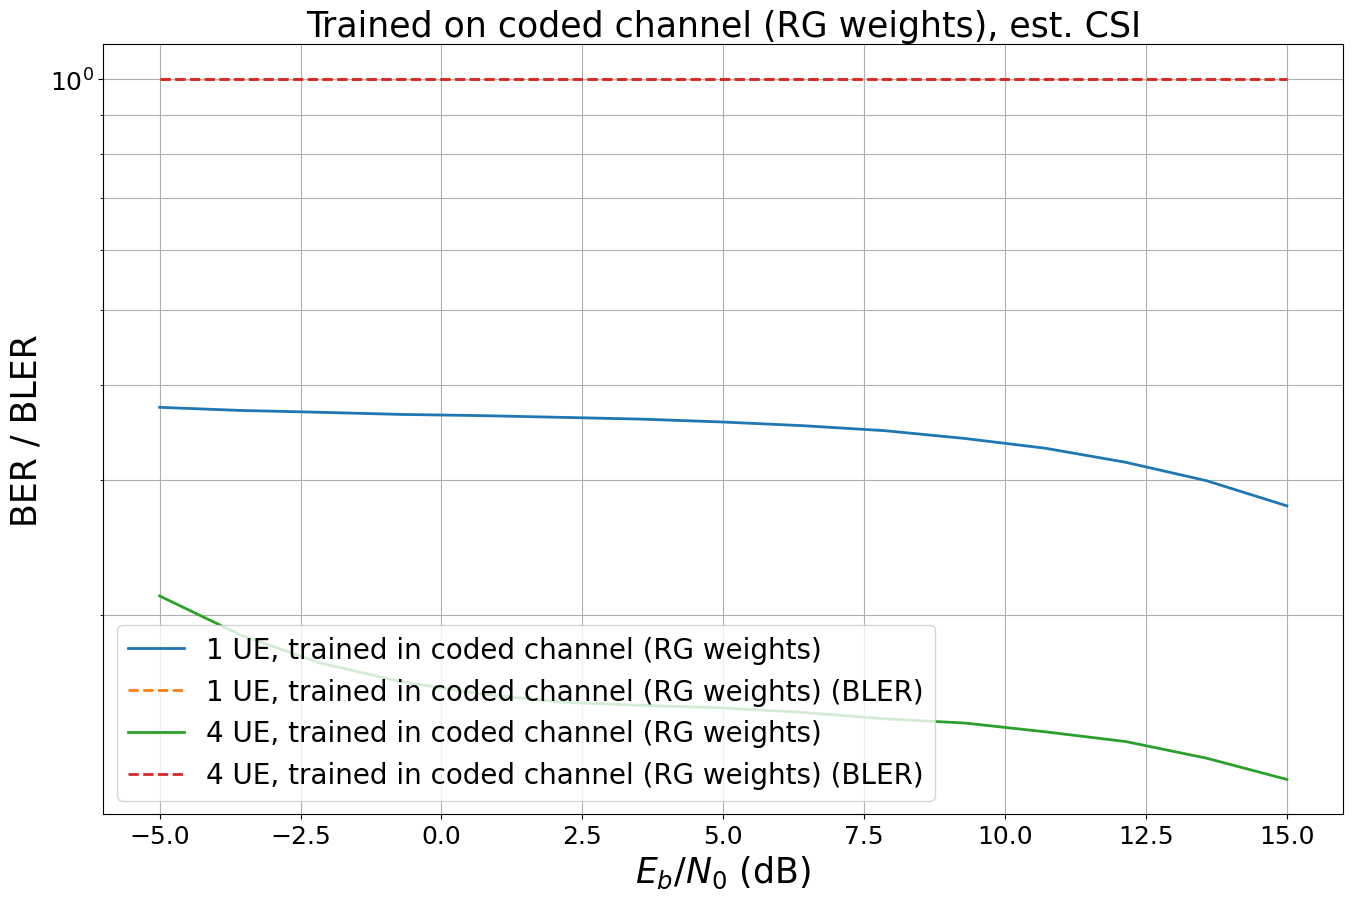

In [5]:
ber_plots.title = "Trained on coded channel (RG weights), est. CSI"
ber_plots()

In [6]:
ber_plots.reset()
sim.BATCH_SIZE = 32
sim.MAX_MC_ITER = 150
num_ue = [1, 4]
for num in num_ue:
    filename = f"weights/ue_{num}_coded_symbol_weights_real.pickle"
    my_model_parameters = {**model_parameters,
                           "jammer_parameters": {**jammer_parameters, "trainable_mask": tf.ones([14,1], dtype=tf.bool)}}
    model = Model(**my_model_parameters)
    load_weights(model, filename)
    simulate_model(model, f"{num} UE, trained in coded channel (symbol weights)", add_bler=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.7950e-01 | 1.0000e+00 |     2098478 |     5529600 |         4800 |        4800 |        25.7 |reached max iter       
   -3.571 | 3.7653e-01 | 1.0000e+00 |     2082056 |     5529600 |         4800 |        4800 |        19.1 |reached max iter       
   -2.143 | 3.7501e-01 | 1.0000e+00 |     2073648 |     5529600 |         4800 |        4800 |        19.0 |reached max iter       
   -0.714 | 3.7393e-01 | 1.0000e+00 |     2067686 |     5529600 |         4800 |        4800 |        19.0 |reached max iter       
    0.714 | 3.7320e-01 | 1.0000e+00 |     2063637 |     5529600 |         4800 |        4800 |        19.0 |reached max iter       
    2.143 | 3.7333e-01 | 1.0000e+00 |     2064340 |     5529600 |         4800 |     

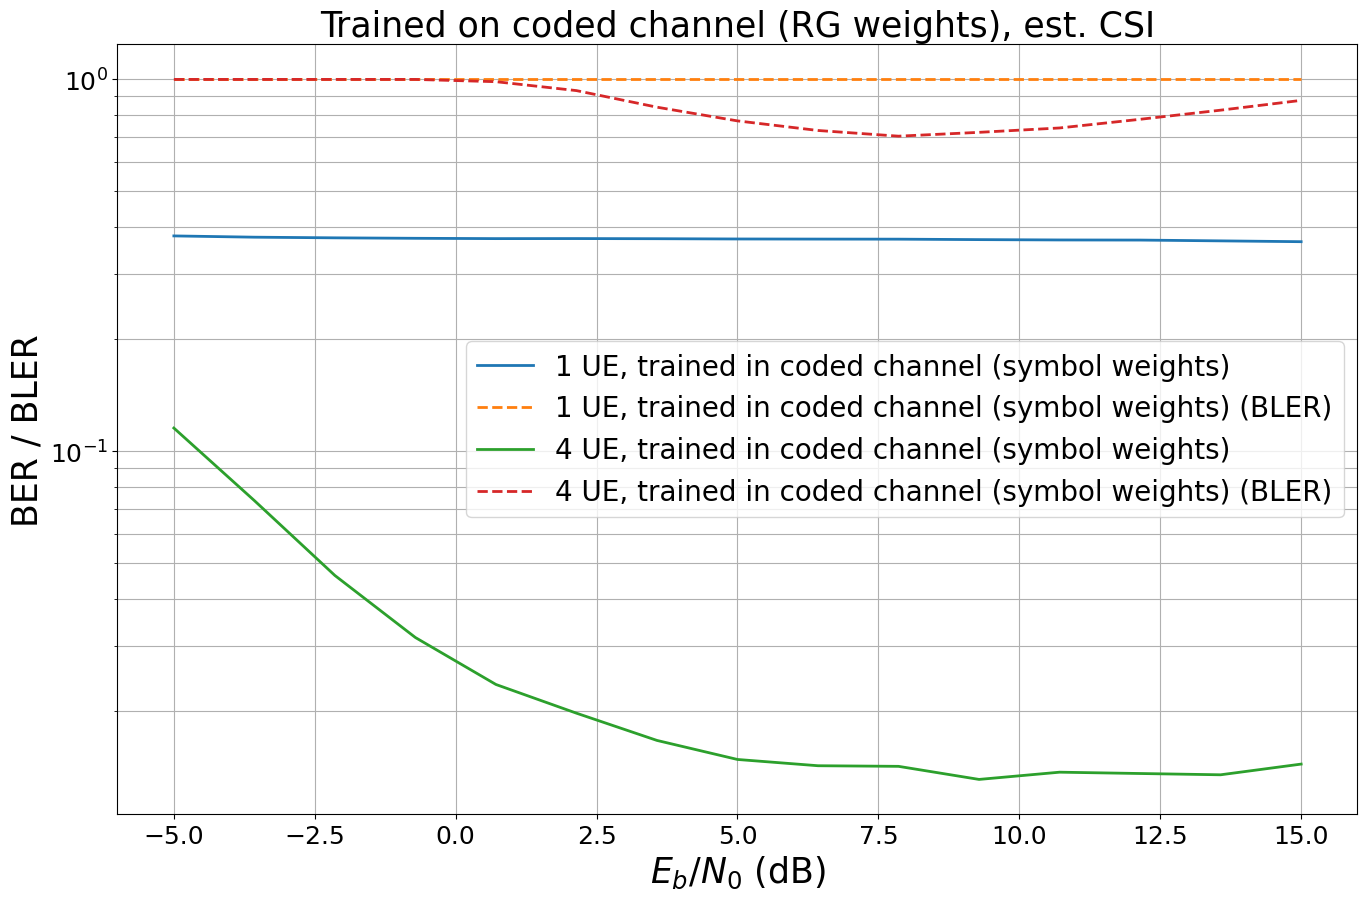

In [7]:
ber_plots.title = "Trained on coded channel (RG weights), est. CSI"
ber_plots()